In [1]:
import numpy as np
import csv
import sklearn as sk
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import linalg
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.covariance import GraphLassoCV, GraphLasso,ledoit_wolf

In [4]:
data=[]
with open('price_demand.csv','rU') as cvsfile:
    cvs_f= csv.reader(cvsfile, delimiter=',')
    next(cvs_f)
    for row in cvs_f:
        data.append(row)
# Transform data from list to array
data = np.asarray(data)
data=data.astype(np.float)

/Users/mathildebadoual/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 'U' mode is deprecated
  


In [7]:
print ('max price: $/MW')
print (max(data[:,5]))
print ('min price: $/MW')
print (min(data[:,5]))
print ('max demand: MW')
print (max(data[:,4]))
print ('min demand: MW')
print (min(data[:,4]))

max price: $/MW
187.891
min price: $/MW
14.71402
max demand: MW
23169.96
min demand: MW
8288.28


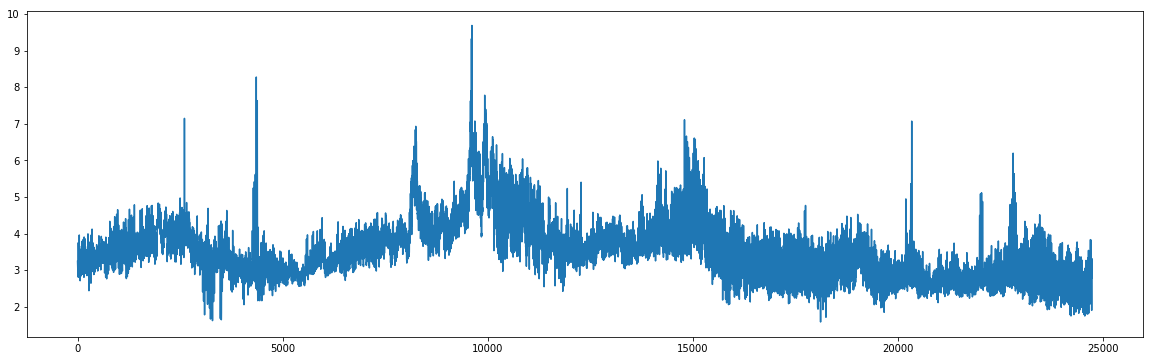

In [6]:
# Ratio of DAM price and DAM demand
plt.figure(figsize=(20,6))
plt.plot(1000*data[:,5]/data[:,4])

# Objective

We want to predict the day ahead price for each hour. When participating to the DAM market, LSEs (Load Serving Entities) have to make their bids (consisting of a quantity in MW and a marginal price in $ per MW). The total demand is something known by the LSE when making this bid (CAISO provides it). Predicting the price is of prime importance for the LSE for two reasons: 
- make sure price bid is lower than the clearing price 
- Adjust quantities wisely along the different hours

This problem of price prediction is non trivial regarding demand. As it can be seen, there is not a simple link between price and demand. Price formation is complex. First, technically, the DAM price of electricity depends on prices of some commodities (e.g. natural gas), it depends on the moment of the day (e.g. solar production at noon with zero marginal cost) and on some technical aspect of production means (e.g. a nuclear plant have limited power ramping constraints). But DAM prices also depend on the bidding strategies (ENRON and the California Electricity Crisis of the 2000s is an example of market power/price distortion).

# Adding explanatory variables from the data itself

In [6]:
# Number of previous days to look at in order to make the day ahead price prediction 
day_window=7
# Create new dataset
data_pass=np.zeros([len(data),12])
data_pass[:,:5]=data[:,:5]
data_pass[:,11]=data[:,5]
num_hours=day_window*24
total_n_days=len(data)/24
index=0
for day in range(1,total_n_days):
    if day-day_window<=0:
        window=day
    else:
        window=day_window
    set_window=range((day-window)*24,day*24)
    set_day=range(day*24,(day+1)*24)
    
    max_price=max(data[set_window,5])
    av_price=np.mean(data[set_window,5])
    min_price=min(data[set_window,5])
    max_demand=max(data[set_window,4])
    av_demand=np.mean(data[set_window,4])
    min_demand=min(data[set_window,4])
    
    for hour in set_day:
        data_pass[hour,5]=max_price
        data_pass[hour,5]=av_price
        data_pass[hour,7]=min_price
        data_pass[hour,8]=max_demand
        data_pass[hour,9]=av_demand
        data_pass[hour,10]=min_demand



# Random Forest Regression for prediction

In [7]:
# Let us test a Random Forest Regression with the data without the extra features
msk=[]
d=0
boolean=False
for h in range(len(data)):
    day=data[h,2]
    if day!=d:
        boolean=np.random.rand()<0.8
        d=day
    msk.append(boolean)
msk=np.asarray(msk)

data_train=data[msk]
data_test=data[~msk]
X_train=data_train[:,:5]
Y_train=data_train[:,5]
X_test=data_test[:,:5]
Y_test=data_test[:,5]
rfr=RFR(n_estimators=10)
rfr=rfr.fit(X_train,Y_train)
Y_predict=rfr.predict(X_test)
RMSE=mse(Y_predict,Y_test)**0.5
print RMSE

3.75491101084


In [8]:
# Let us test a Random Forest Regression with the data with extra features
msk=[]
d=0
boolean=False
for h in range(len(data)):
    day=data[h,2]
    if day!=d:
        boolean=np.random.rand()<0.8
        d=day
    msk.append(boolean)
msk=np.asarray(msk)
    
data_train=data_pass[msk]
data_test=data_pass[~msk]
X_train=data_train[:,:11]
Y_train=data_train[:,11]
X_test=data_test[:,:11]
Y_test=data_test[:,11]
rfr=RFR(n_estimators=50)
rfr=rfr.fit(X_train,Y_train)
Y_predict=rfr.predict(X_test)
RMSE=mse(Y_predict,Y_test)**0.5
print RMSE

4.62518851601


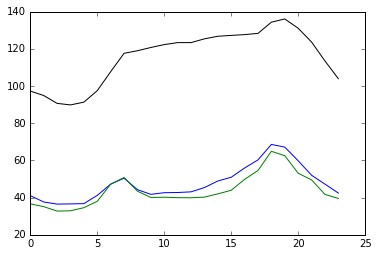

In [9]:
d=129
# in blue the DAM price prediction
plt.plot(Y_predict[d*24:(d+1)*24],'b')
# in green the actual DAM price
plt.plot(Y_test[d*24:(d+1)*24],'g')
# in Black the corresponding demand 
plt.plot(X_test[d*24:(d+1)*24,4]/100,'black')

In [10]:
# Training on the whole dataset
X=data_pass[:,:11]
Y=data_pass[:,11]
rfr=rfr.fit(X,Y)
Y_predict=rfr.predict(X)

# Covariance matrix computation

 First let us build a list of errors, one element of the list being an element of $\mathbb{R}^{24}$ corresponding to error vector for a given day

In [11]:
error_list=[]
for day in range(0,total_n_days):
    set_day=range(day*24,(day+1)*24)
    error=Y_predict[set_day]-Y[set_day]
    error_list.append(error)
    

First let us check that the mean of this list is equal to the vector of lenght 24 and with only zeros as components. We find that it is the case if we consider a 0.5 $ accuracy. Nevertheless we will consider this average in the covariance matrix computation in order to be more accurate. 

In [12]:
av_error=sum(error_list)/total_n_days
print av_error

[-0.00254815  0.01558618  0.11617848  0.00647592 -0.0670005  -0.11971327
 -0.06474248 -0.0397152   0.08844733  0.04165236  0.01345878 -0.03066529
  0.04015905  0.08385873  0.09940403 -0.07080675  0.14612566 -0.24628304
 -0.33915088  0.19311003  0.16740987  0.04435389  0.02267601 -0.02037206]


Let us make the hypothesis that the error follows a multivariate normal distribution. It is known that the Maximum likelihood for a covariance matrix describing the data is the following covariance matrix estimation:

$$\Sigma_{i,j}=\mathbb{E}((\epsilon_i-\bar{\epsilon_i}) (\epsilon_j-\bar{\epsilon_j})$$ 
With $\epsilon_i$ the random variable corresponding to the hour $i$. An estimate for this matrix is: $$\Sigma_{i,j}=\frac{1}{N_{day}}\sum_{k=1}^{N_{day}} (\epsilon_i(k)-\bar{\epsilon_i}) (\epsilon_j(k)-\bar{\epsilon_j}) $$
With $\epsilon_i(k)$ the error of the k-th element in the error list at time $i$ and $\bar{\epsilon_i}=\frac{1}{N_{day}}\sum_{k=1}^{N_{day}} \epsilon_i(k)$

In [13]:
sigma=np.zeros([24,24])
for i in range(24):
    for j in range(24):
        epsilon=0
        for k in range(total_n_days):
            epsilon=epsilon+(error_list[k][i]-av_error[i])*(error_list[k][j]-av_error[j])
        sigma[i,j]=epsilon/total_n_days
            

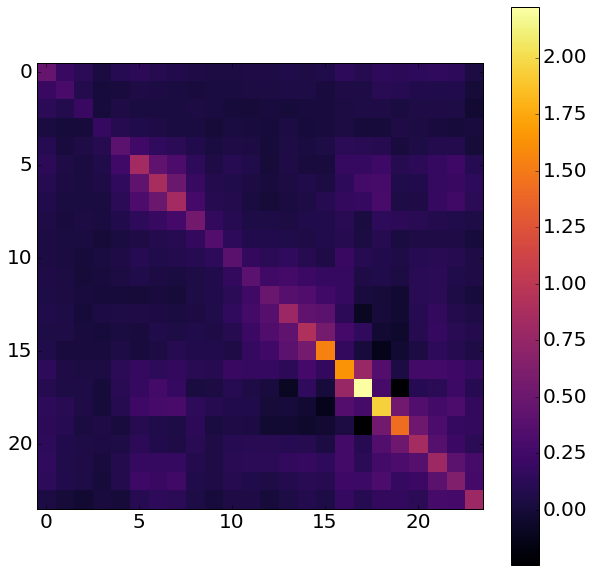

In [14]:
fig = plt.figure(figsize=(10,10))

plt.rcParams.update({'font.size':20})
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.imshow(sigma, interpolation='nearest', cmap=plt.cm.inferno)
plt.colorbar()
plt.show()


# Analysis of the covariance matrix

We know that the diagonal of the matrix represents the variance of the error. We can see that the highest error on prediction is being made between 5PM and 7PM, which is basically the time for which the net demand peaks (and important ramping, cf. duck curve). 

We can see that at some moment of the day the error repercusion from one hour to the other is quite high: between 6AM and 7AM (the moment when people get up and commute, apparently, personnally I think it's an ungodly hour). Around 12 PM and between 6PM and 10 PM we can also see this phenomenon. 

Unexpectedly we can see that the error made at 7AM has a relative repercusion on the error made at 6PM.


# Simulation of DAM Price


We do a Cholesky decompostion on the covariance matrix $\Sigma$. We write: $\Sigma=LL^T $. 
For a given day, if we assue the error to be multivariate gaussian, we have a simultion given by:
$$ Price_{simulation}=Price_{prediction}+Lu$$
With $u$ a multivariate random variable following a zero centered gaussian distribution of variance $1$.

In [15]:
L=np.linalg.cholesky(sigma)
# Choose the day for the simulation
d=306
set=range(d*24,(d+1)*24)
# Choose the number of simulations
n_sim=3
Y_simu=[]
for simu in range(n_sim):
    u=np.random.multivariate_normal(np.zeros(len(L)),np.identity(len(L)))
    YY=Y_predict[set]+np.dot(L,u)
    Y_simu.append(YY)


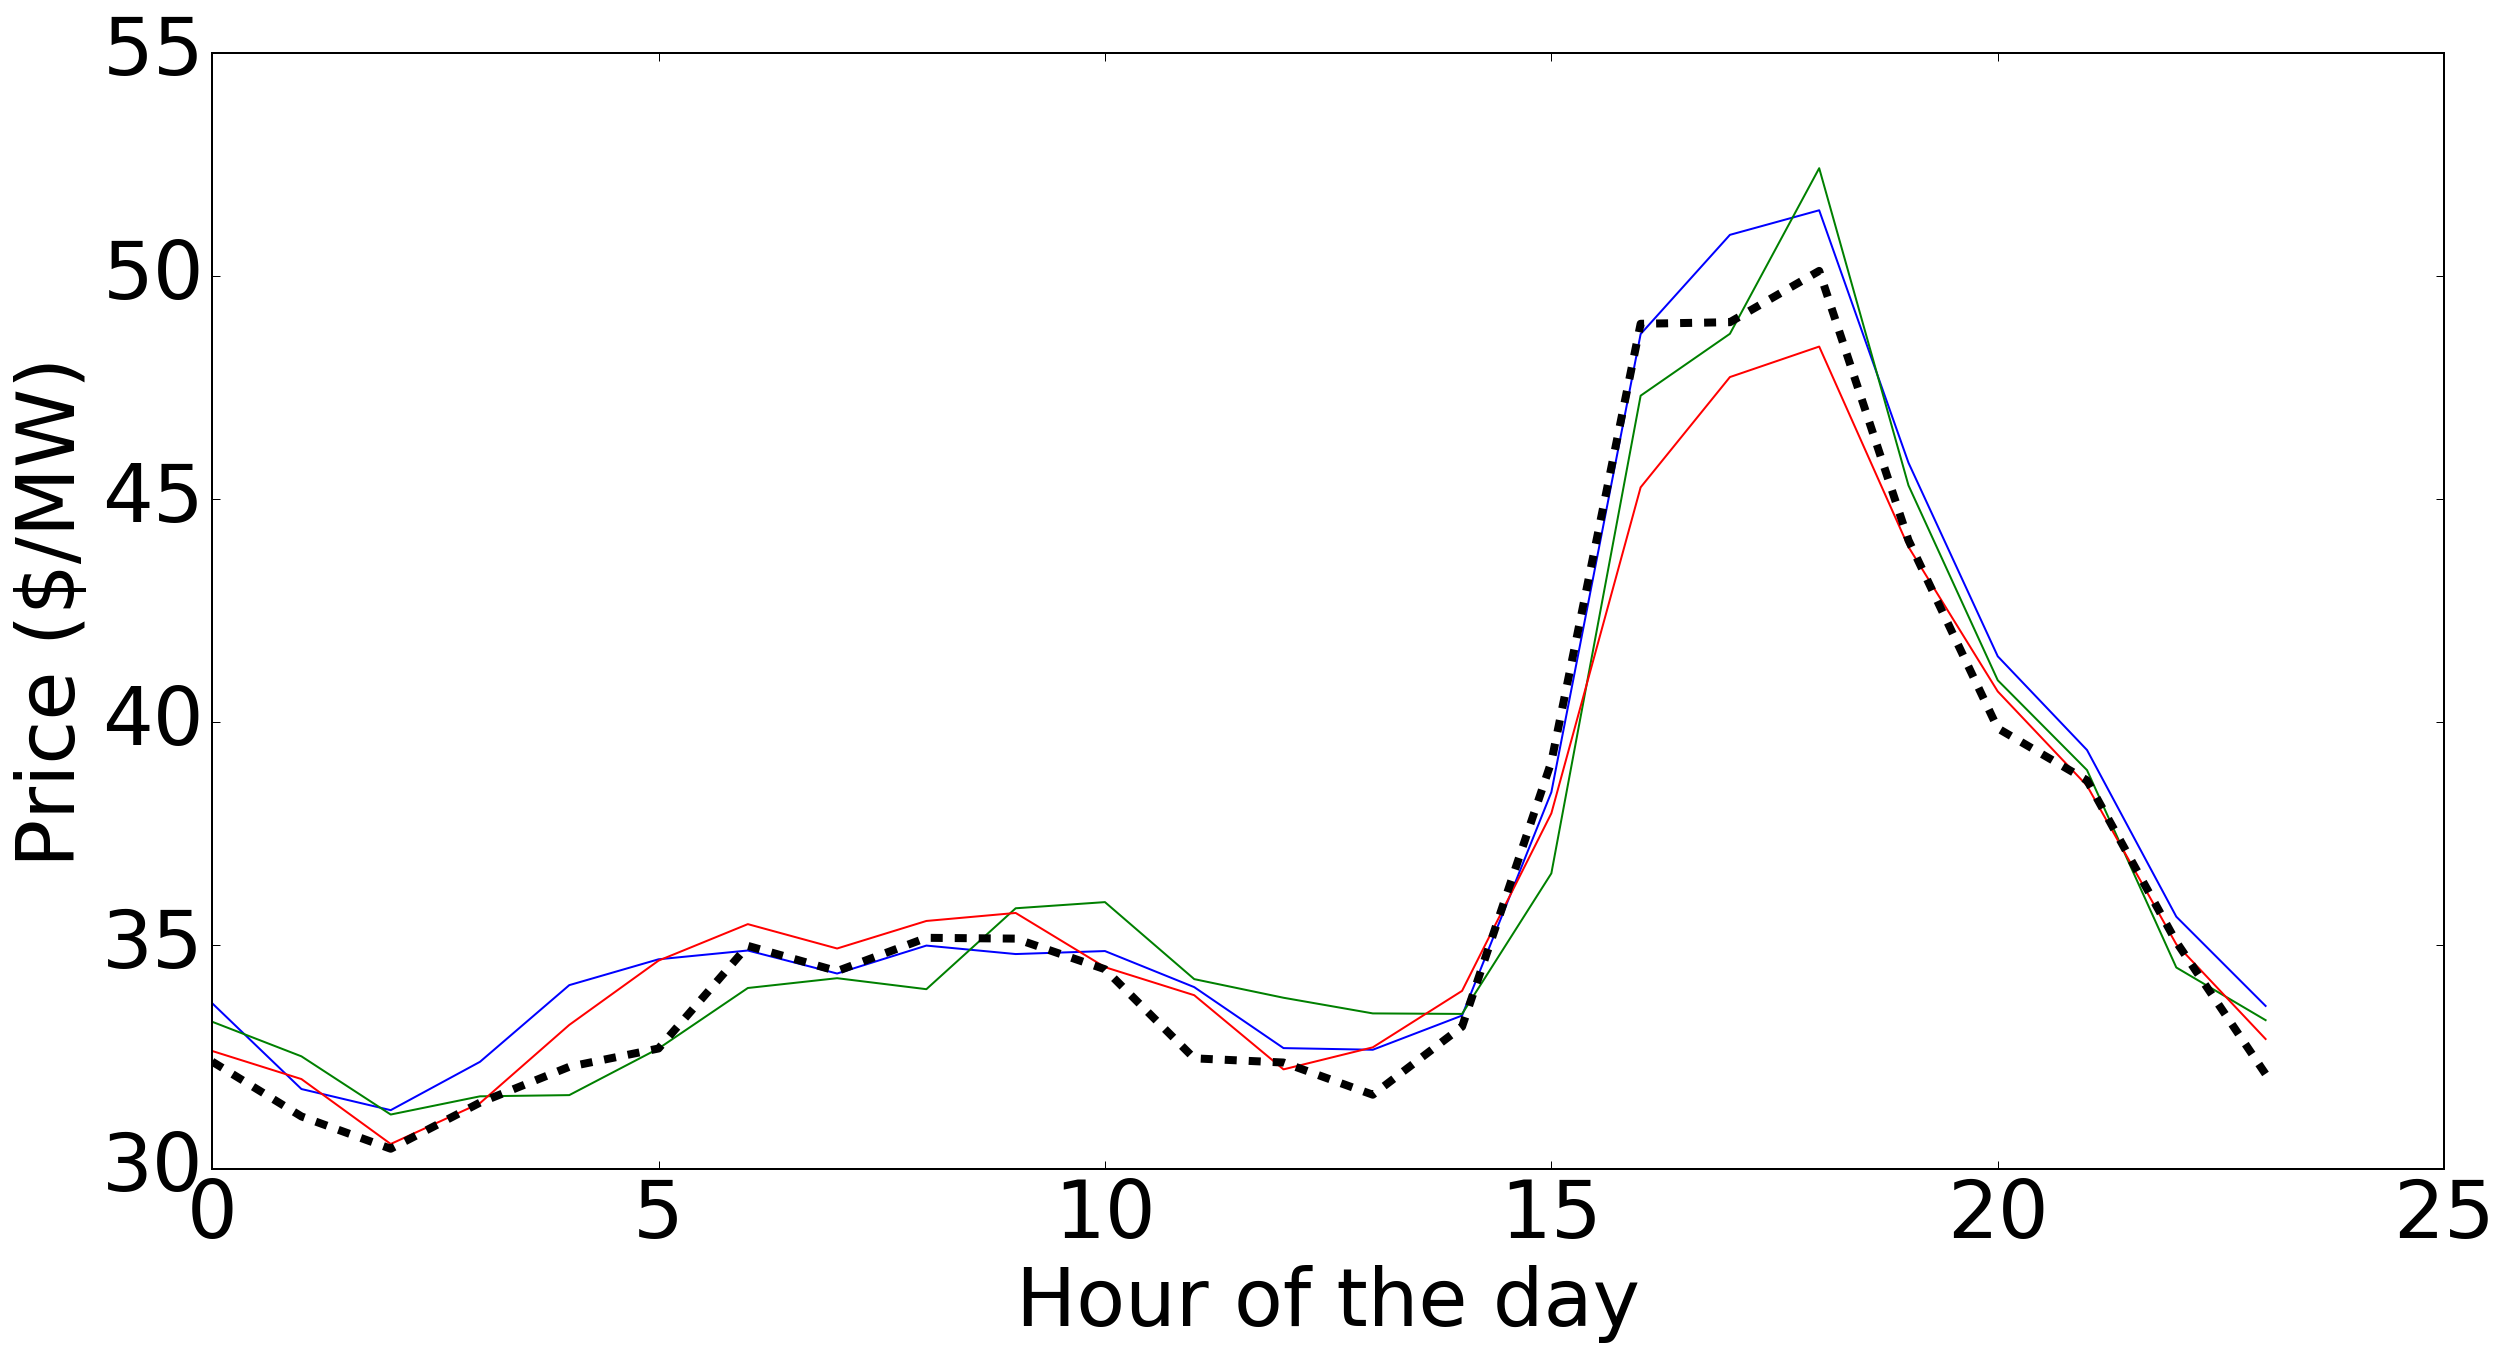

In [16]:
%config InlineBackend.figure_format = 'retina'
fig = plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size':40})
plt.ylabel('Price ($/MW)')
plt.xlabel('Hour of the day')
for simu in range(n_sim):
    plt.plot(Y_simu[simu])
plt.plot(Y[set],'r--',color='black',linewidth=4)


# Sparse Covariance Matrix Estimation (Graph Lasso Covariance)

We want this covariance to be more explanatory, i.e build stronger link between the error of one hour to the other. The theory we use comes from the following paper: Sparse inverse covariance estimation with the graphical lasso by
Jerome Friedman (2007). Luckily, the corresponding algorithm was already implemented in sklearn. 
![Illustration of Graph Lasso with different regularization parameters](graph_lasso_illustration.png)

In [17]:
error_array= np.asarray(error_list)
model = GraphLasso(alpha=0.05)
model.fit(error_array)
sigma_sparse= model.covariance_

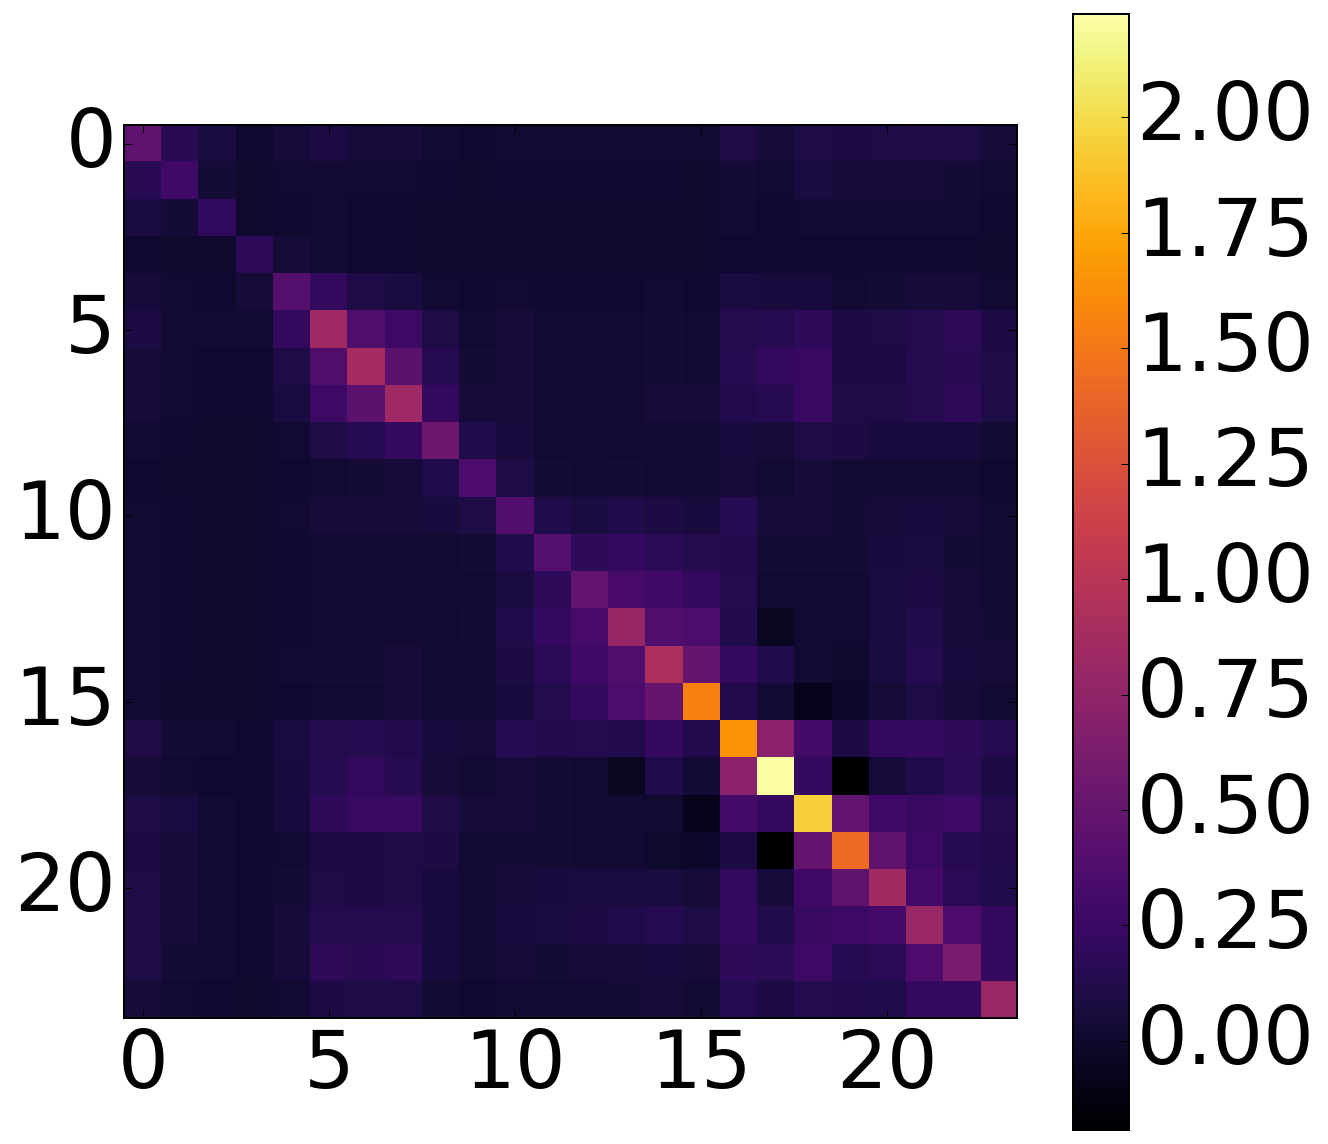

In [18]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.imshow(sigma_sparse, interpolation='nearest', cmap=plt.cm.inferno)
plt.colorbar()
plt.show()

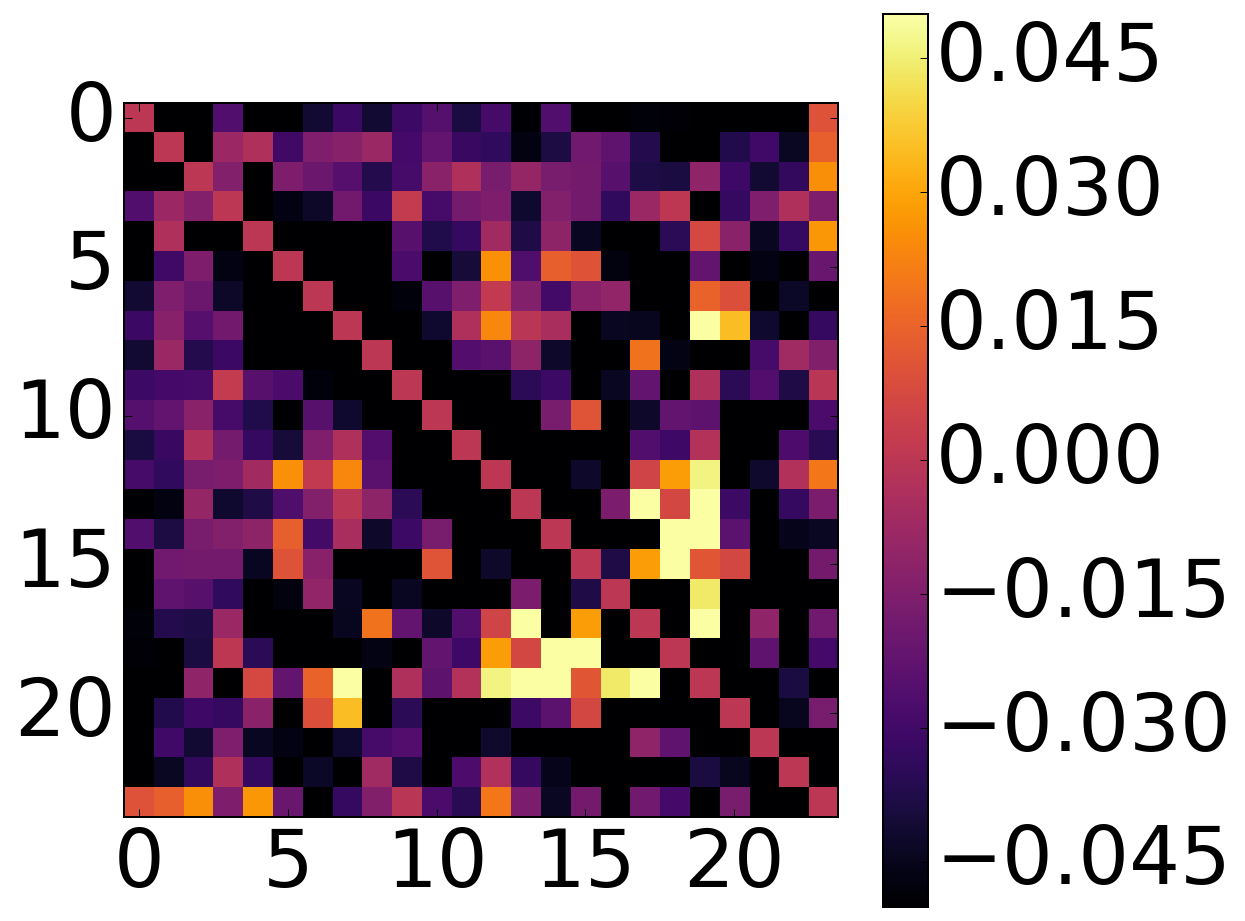

In [19]:
# Look at the difference between the two covaraiance estimates
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.imshow(sigma_sparse-sigma, interpolation='nearest', cmap=plt.cm.inferno)
plt.colorbar()
plt.show()

In [20]:
sigma_sparse
# Save CVS file
csvfile = "covariance.csv"
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in sigma_sparse:
        writer.writerow(val)


# Random Forest Regression: Online learning

In [21]:
# Let us train on the first two years first. And then apply online learning...
# Initialize the training data set
X_train=data[:2*365*24,:5]
Y_train=data[:2*365*24,5]

rfr=RFR(n_estimators=10)
rfr=rfr.fit(X_train,Y_train)
Y_predict=rfr.predict(X_train)
RMSE=mse(Y_predict,Y_train)**0.5
print 'The training error is %s $' %RMSE

The training error is 1.19189853486 $


In [34]:
# Now, let us do 'online' learning: to predict tomorrow's price we use all the knowlege we gained so far
RMSE_list=[]
error_list2=[]
price_prediction=[]
price_realized=[]
for day in range(100):
    X_train=data[:2*365*24+day*24,:5]
    Y_train=data[:2*365*24+day*24,5]
    X_predict=data[2*365*24+day*24:2*365*24+(day+1)*24,:5]
    Y_realized=data[2*365*24+day*24:2*365*24+(day+1)*24,5]
    rfr=RFR(n_estimators=10)
    rfr=rfr.fit(X_train,Y_train)
    Y_predict=rfr.predict(X_predict)
    RMSE=mse(Y_predict,Y_realized)**0.5
    RMSE_list.append(RMSE)
    error=Y_predict-Y_realized
    error_list2.append(error)
    price_prediction.append(Y_predict)
    price_realized.append(Y_realized)

In [23]:
np.mean(RMSE_list)

3.4321457736943075

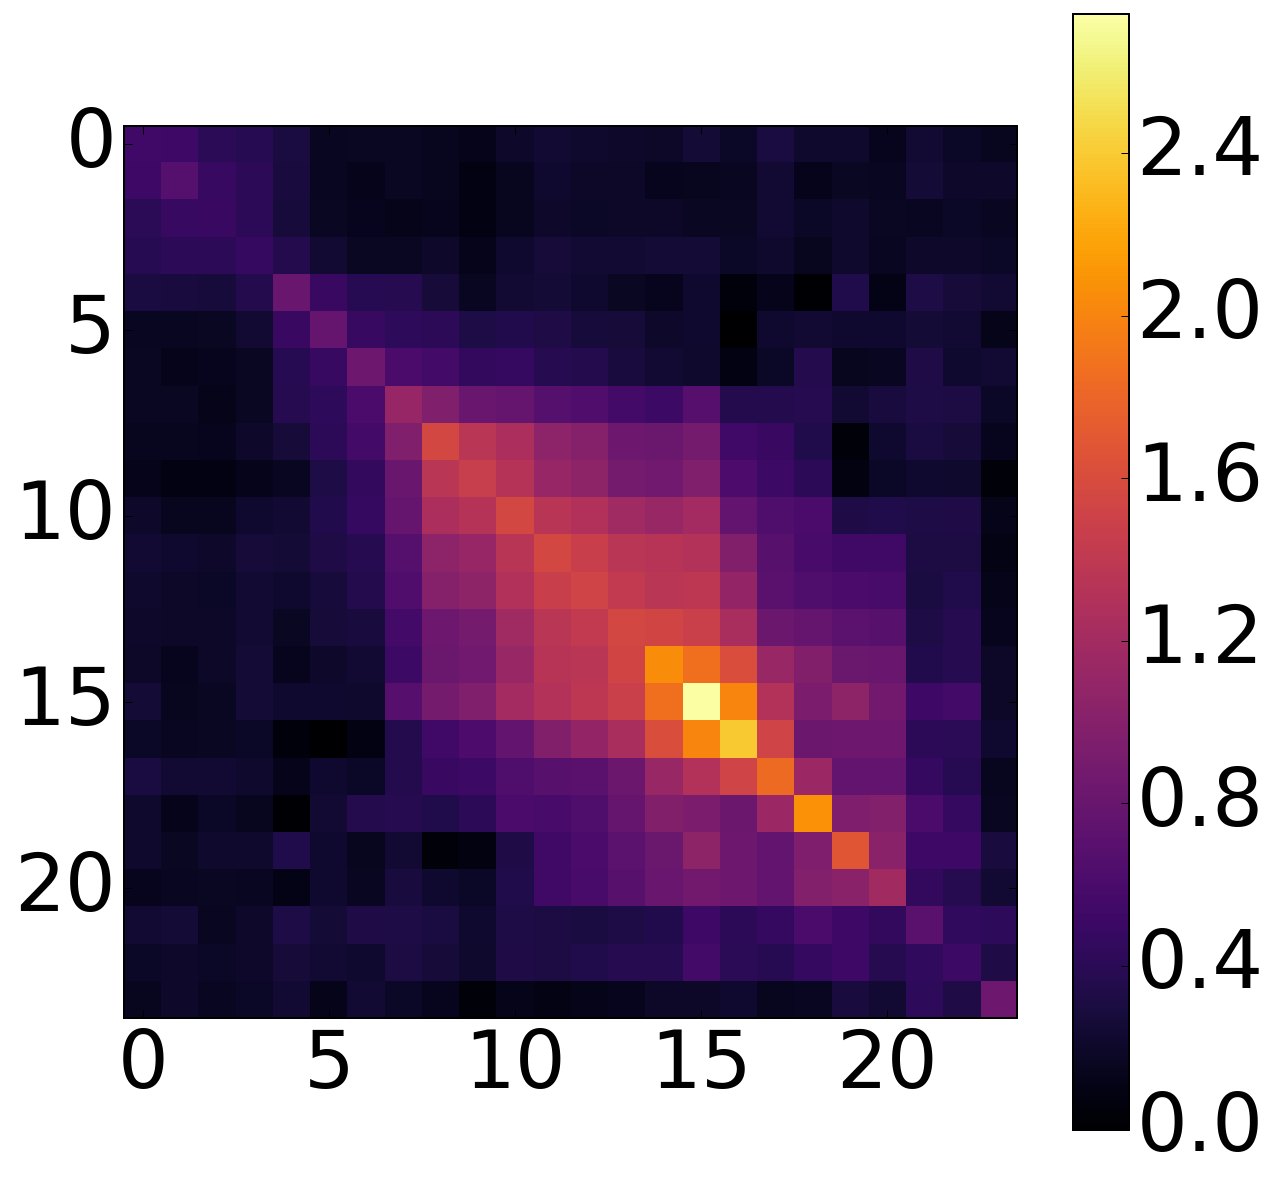

In [41]:
error_array= np.asarray(error_list2)/10
model = GraphLasso(alpha=0.0)
model.fit(error_array)
sigma_sparse= model.covariance_
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.imshow(10*sigma_sparse, interpolation='nearest', cmap=plt.cm.inferno)
plt.colorbar()
plt.show()


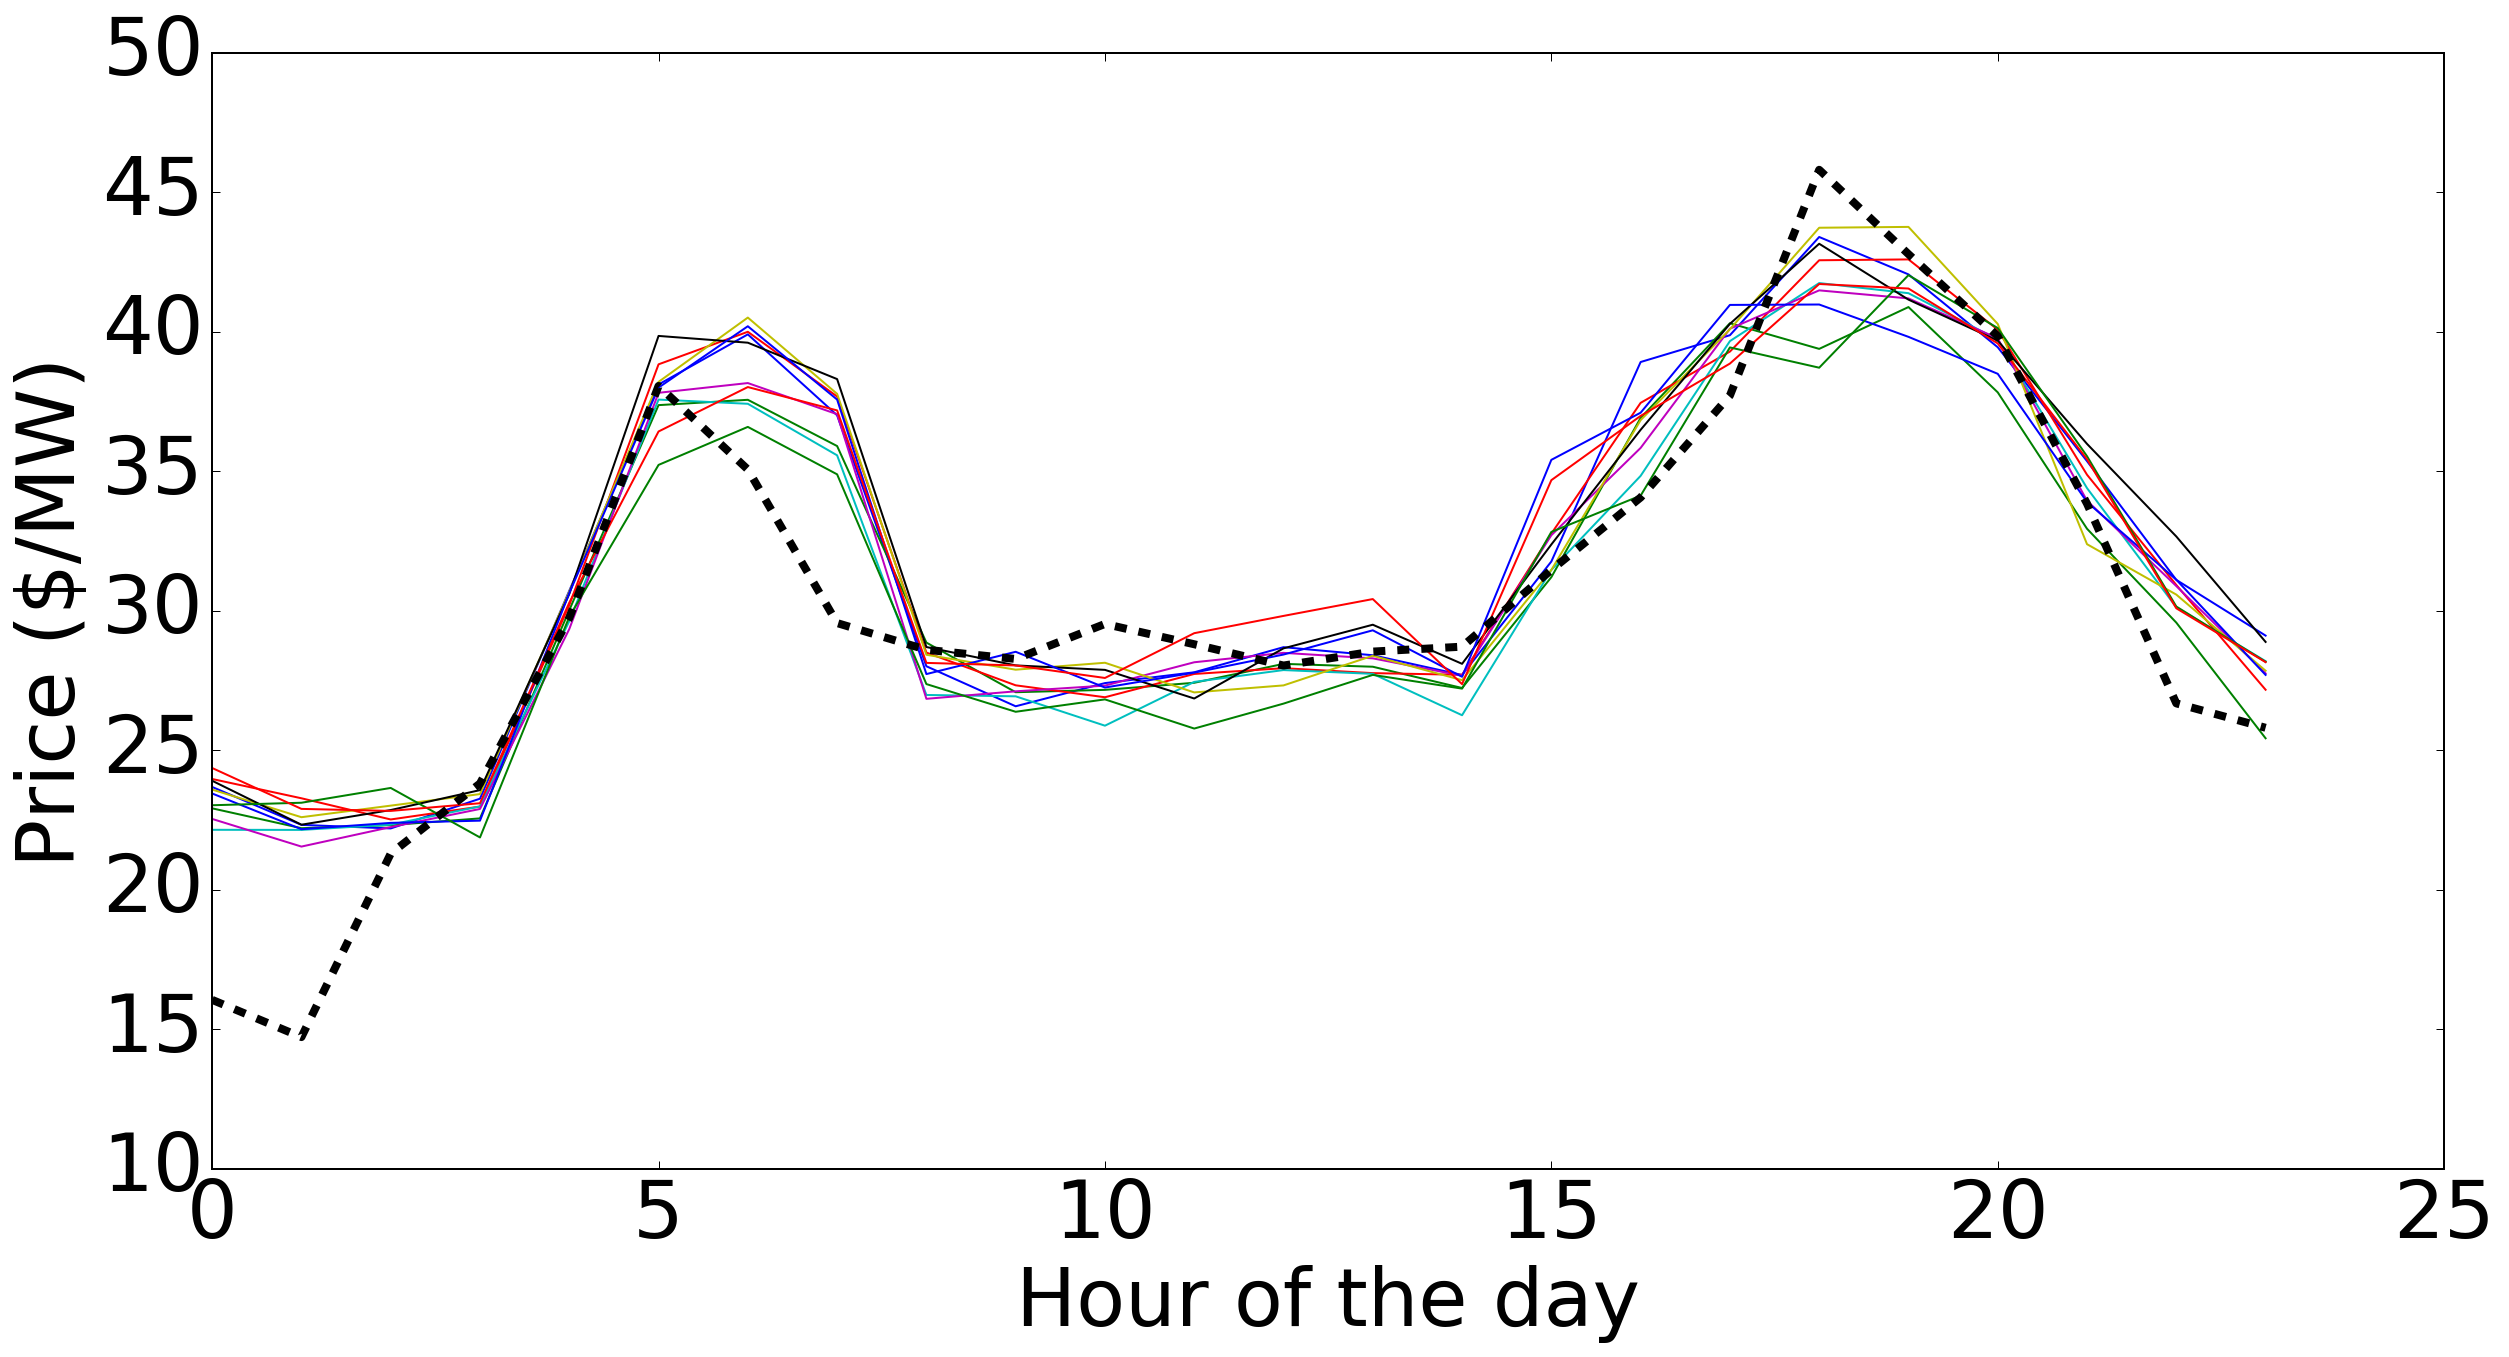

In [44]:
L=np.linalg.cholesky(sigma)
# Choose the day for the simulation
day=25
Y_predict=price_prediction[day]
Y_realized=price_realized[day]
set=range(d*24,(d+1)*24)
# Choose the number of simulations
n_sim=10
Y_simu=[]
for simu in range(n_sim):
    u=np.random.multivariate_normal(np.zeros(len(L)),np.identity(len(L)))
    YY=Y_predict+np.dot(L,u)
    Y_simu.append(YY)
%config InlineBackend.figure_format = 'retina'
fig = plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size':40})
plt.ylabel('Price ($/MW)')
plt.xlabel('Hour of the day')
for simu in range(n_sim):
    plt.plot(Y_simu[simu])
plt.plot(Y_realized,'r--',color='black',linewidth=4)


In [30]:
Y_simu

[array([ 25.49349073,  26.10163294,  25.84037461,  25.66809235,
         30.30485945,  36.07017117,  42.4624662 ,  33.8091026 ,
         31.33956056,  29.47185985,  29.41498342,  29.01276054,
         29.93079759,  29.91880173,  30.12498152,  33.93762702,
         36.54942483,  44.51238292,  47.164846  ,  45.88599845,
         39.81944758,  38.96296491,  30.34799902,  27.70351635]),
 array([ 26.03735349,  26.14901619,  25.902829  ,  25.61803286,
         30.55656128,  35.4612232 ,  42.67605077,  34.10130213,
         31.8564731 ,  30.00574581,  29.80869667,  29.55594881,
         29.68567688,  30.97371408,  31.09574484,  34.29639675,
         36.61659198,  44.98820752,  47.02886188,  45.85116669,
         38.81323724,  39.51535088,  30.34457588,  28.32334505]),
 array([ 25.80921076,  25.72390986,  26.03983577,  25.57921922,
         30.3609805 ,  35.57660358,  42.06262723,  33.51717498,
         31.50924796,  29.12074462,  28.7557409 ,  28.92366096,
         28.97730351,  30.41212476, 